In [1]:
'''
=========================================================================
OSE bootcamp 2019
Week 4, Firm Dynamics [ Thomas Winberry's lecture ]
Problem Set: Firm Entry and Exit
(Based on Clementi and Palazzo AEJ Macro 2016)

By Dohan Kim (UPenn), 2019 July
=========================================================================
'''

import numpy as np
import sympy as sy
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import quantecon as qe
from quantecon.optimize.scalar_maximization import brent_max
from scipy.optimize import brentq, newton
from scipy.optimize import fsolve
from numba import njit
import time
from numpy import linalg as LA
import numpy.matlib
from bisect import bisect
import sys

In [2]:
# Parameters
θ = 0.21
ν = 0.64
δ = 0.10
β = 0.96
φ = 0.50
ρ = 0.90
σ = 0.02

params = (θ, ν, δ, β, φ, ρ, σ)

In [3]:
'''
-------------------------------------------------
 2. Solve for representative agent steady state
-------------------------------------------------
'''

Nss = 0.6   # steady state labor supply
ϵss = 0.0   # mean of the idiosyncratic shock

def compute_Kss_wss(Nss, ϵss, params):
    '''
    This function computes the steady state capital stock and wage
    of the representative agent model.

    [ Parameters ]
        Nss : the steady state labor supply
        ϵss : the mean of the idiosyncratic shock
        params : theta, nu, delta, beta, varphi, rrho, sigma

    [ Return ]
        Kss : the steady state capital stock
        wss : the steady state wage level
    '''
    
    θ, ν, δ, β, φ, ρ, σ = params
    
    Kss = ((1 + φ*δ - β * ((1-δ) + φ*δ - 0.5*φ*δ**2))
           / (β*np.exp(ϵss)*θ*(Nss)**ν))**(1/(θ-1))

    wss = ν*np.exp(ϵss)*(Kss**θ)*(Nss**(ν-1))

    return Kss, wss


Kss, wss = compute_Kss_wss(Nss, ϵss, params)
print("Kss = %4.3f" % Kss)
print("wss = %4.3f" % wss)

Kss = 1.045
wss = 0.776


In [4]:
'''
-----------------------------------------------
 3. Solve for incumbent firms' decision rules
-----------------------------------------------
'''

#--------------------------- 
# Value Function Iteration
#---------------------------

def VFI(w, kss, nk, nϵ, Cf, params, Max_Iter=1000, tol=1e-5, seeIter=50):
    '''
    This function implements the value function iteration.

    [ Parameters ]
        w        : wage
        kss      : the steady state capital stock
        nk       : a number of points for capital
        nϵ       : a number of points for idiosyncratic shock
        Cf       : a fixed cost that incumbent firms pay to operate
        params   : theta, nu, delta, beta, varphi, rrho, sigma
        Max_Iter : the maximum number of iteration (default = 1000)
        tol      : a tolerance level (default = 1e-5)
        seeIter  : show the difference per "seeIter" iterations ('0' : do not show)

    [ Return ]
        mV    : the value function V(k,ϵ)
        mPd   : the optimal operation decision d(k,ϵ)
        mPk   : the optimal capital choice k(k,ϵ)
        mPn   : the optimal labor choice n(k,ϵ)
        kgrid : the grid for k (capital)
        ϵgrid : the grid for ϵ (idiosyncratic shock)
        MC    : the markov chain for ϵ
    '''
    #--------
    # Set up
    #--------
    
    θ, ν, δ, β, φ, ρ, σ = params

    kgrid = np.linspace(0, kss*2.5, nk) # capital grid
    
    # use Tauchen's method to approximate the process with a Markov chain
    mc = qe.markov.approximation.tauchen(ρ, σ, b=0, m=3, n=nϵ)
    ϵgrid = mc.state_values   # grids of idiosyncratic shocks (ϵ)
    MC = mc.P                 # Markov chain matrix

    # required matrices and vectors
    mY = np.zeros((nk,nϵ), dtype=float)    # save values for output
    mPn = np.zeros_like(mY)                # save optimal labor choice
    
    mV = np.ones((nϵ,nk))*kgrid*(1-δ)      # save values for value function
    mV = np.transpose(mV)                  # initial guess : (1-δ)*k
    
    # compute output and labor demand decision for each pair of state variables
    for ik in range(nk):
        k = kgrid[ik]
        for iz in range(nϵ):
            ϵ = ϵgrid[iz]
            if k == 0:
                mPn[ik,iz] = 0.0
                mY[ik,iz] = 0.0
            else:
                mPn[ik,iz] = (w / (np.exp(ϵ)*ν*k**θ))**(1/(ν-1))
                mY[ik,iz] = np.exp(ϵ)*(k**θ)*(mPn[ik,iz]**ν)
    
    @njit
    def compute_v1(kp, iz, k, n, y, mV):
        '''
        This function computes values for the value function

        [ Parameters ]
            kp : capital choice for tomorrow
            iz : the current shock index
            k  : today's capital stock
            n  : labor choice
            y  : the current output
            mV : the value function v(k,ϵ)
        
        [ Return ]
            v1 : the value for value function
        '''
        
        eV = np.zeros(nϵ)
        
        for izp in range(nϵ):
            eV[izp] = np.maximum(np.interp(kp,kgrid[1:],mV[1:,izp]),(1-δ)*kp)
        if k == 0: # the firm exits
            v1 = - kp + β*np.dot(eV, MC[iz,:])
        else: # the firm operates
            dividend = - Cf + y - w*n - (kp-(1-δ)*k) - 0.5*φ*k*(kp/k-(1-δ))**2
            if dividend < 0:
                v1 = -1e+10
            else:
                v1 = dividend + β*np.dot(eV, MC[iz,:])
            
        return v1
    
    @njit
    def BellmanOperator(mV, mY, mPn):
        '''
        The Bellman operator
        
        [ Parameters ]
            mV  : the current value function V(k,ϵ)
            mY  : the computed output
            mPn : the computed optimal labor n(k,ϵ)
            
        [ Returns ]
            mVnew : the new value function V(k,ϵ)
            mPd   : the optimal operation decision d(k,ϵ)
            mPk   : the optimal capital choice k(k,ϵ)
        '''

        mVnew = np.zeros_like(mV) # mVnew = T(mV)
        mPd = np.zeros_like(mV)   # save optimal capital choice
        mPk = np.zeros_like(mV)   # save optimal operation choice (0 or 1)
        for ik in range(1,nk):
            k = kgrid[ik]
            v0 = (1-δ)*k       
            for iz in range(nϵ):
                ϵ = ϵgrid[iz]
                y = mY[ik,iz]
                n = mPn[ik,iz]
                result = brent_max(compute_v1, 1e-10, y-w*n+(1-δ)*k, args=(iz,k,n,y,mV))
                kp = result[0]
                v1_max = result[1]
                if v1_max >= v0:
                    mVnew[ik,iz] = v1_max
                    mPd[ik,iz] = 1
                    mPk[ik,iz] = kp
                else:
                    mVnew[ik,iz] = v0
                    mPd[ik,iz] = 0
                    mPk[ik,iz] = 0
                    
        return (mVnew, mPd, mPk)
    
    #------------
    # Iteration
    #------------
    
    diff = 10
    it = 0

    while (diff > tol) and (it < Max_Iter):
        
        it = it + 1
        mVnew, mPd, mPk = BellmanOperator(mV, mY, mPn)
        
        diff = np.max(np.abs(mV - mVnew))
        mV = mVnew
        
        if seeIter != 0:
            if (it % seeIter == 0) or (it == 1):
                print("   Iteration: %4d,   the maximum difference: %8.6f" % (it, diff))
    
    # compute the entrant's value function (v(ϵ)) and optimal capital choice
    for iz in range(nϵ):
        result = brent_max(compute_v1, 1e-10, kss*3, args=(iz,0,0,0,mV))
        kp = result[0]
        v1_max = result[1]
        if v1_max >= 0:
            mV[0,iz] = v1_max
            mPd[0,iz] = 1
            mPk[0,iz] = kp
        else:
            mV[0,iz] = 0
            mPd[0,iz] = 0
            mPk[0,iz] = 0
        
    mPn = np.multiply(mPn, mPd) # n=0 for new entrants and exiting firms
    
    if seeIter != 0:
        if it % seeIter != 0:
            print("   Iteration: %4d,   the maximum difference: %6.5ef" % (it, diff))
    
    return (mV, mPd, mPk, mPn, kgrid, ϵgrid, MC) 

In [7]:
Cf = 0.01  # a fixed cost that incumbent firms pay to operate
Ce = 0.00  # an entry cost
nk = 100   # a number of points for capital stock (k)
nϵ = 11    # a number of points for idiosyncratic shocks (epsilon)

start = time.time()
mV, mPd, mPk, mPn, kgrid, ϵgrid, MC = VFI(wss, Kss, nk, nϵ, Cf, params, Max_Iter=1000, tol=1e-5, seeIter=50)
end = time.time()
print("Elapsed = %4.2f seconds" % (end - start))

   Iteration:    1,   the maximum difference: 0.373959
   Iteration:   50,   the maximum difference: 0.014759
   Iteration:  100,   the maximum difference: 0.001906
   Iteration:  150,   the maximum difference: 0.000248
   Iteration:  200,   the maximum difference: 0.000033
   Iteration:  231,   the maximum difference: 9.99289e-06f
Elapsed = 12.83 seconds


Text(0, 0.5, 'd')

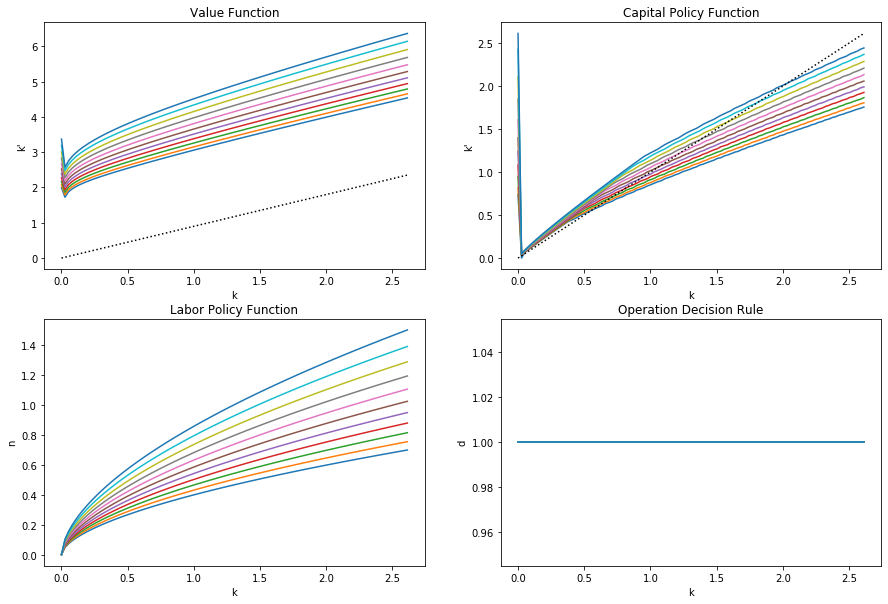

In [8]:
fig1 = plt.figure(figsize = [15, 10])
    
# Plot the value function
VF = fig1.add_subplot(2, 2, 1)
for iz in range(nϵ):
    plt.plot(kgrid, mV[:,iz])
plt.plot(kgrid, kgrid*(1-δ), ':', color='black')
plt.title("Value Function")
plt.xlabel("k")
plt.ylabel("k'")

# Plot the policy function (capital)
VF = fig1.add_subplot(2, 2, 2)
for iz in range(nϵ):
    plt.plot(kgrid, mPk[:,iz])
plt.plot(kgrid, kgrid, ':', color='black')
plt.title("Capital Policy Function")
plt.xlabel("k")
plt.ylabel("k'")

# Plot the policy function (labor)
VF = fig1.add_subplot(2, 2, 3)
for iz in range(nϵ):
    plt.plot(kgrid, mPn[:,iz])
plt.title("Labor Policy Function")
plt.xlabel("k")
plt.ylabel("n")

# Plot the policy function (operation decision)
VF = fig1.add_subplot(2, 2, 4)
for iz in range(nϵ):
    plt.plot(kgrid, mPd[:,iz])
plt.title("Operation Decision Rule")
plt.xlabel("k")
plt.ylabel("d")

In [9]:
'''
--------------------------------------
 4. Compute the market-clearing wage
--------------------------------------
'''

# compute the long-run distribution, ν(ϵ)
def compute_StationaryDist(T):
    ''' 
    This function computes the long-run distribution ν(ϵ)
    x = xT where x is the answer
    x - xT = 0
    x( I - T ) = 0 and sum(x) = 1
    
    [ Parameters ]
        T : the Markov chain
        
    [ Return ]
        ν : the long-run distribution
    '''
    n = T.shape[0]
    a = np.eye(n) - T
    a = np.vstack((a.T, np.ones(n)))
    b = np.matrix([0]*n + [1]).T
    dist = np.linalg.lstsq(a, b, rcond=-1)[0]
    ν = np.squeeze(np.asarray(dist))
    
    return ν

# compute the entry cost (Ce = E(v(k=0,ϵ)))
ν_dist = compute_StationaryDist(MC)
Ce = np.dot(mV[0,:], ν_dist)
print("Ce = %4.2f" % Ce)

Ce = 2.55


In [10]:
'''
=================================================================
 5. Compute the stationary measure of firms and mass of entrants
=================================================================
'''

'''
------------------------------------------------------
 [Step 1] : solve for stationary measure with m* = 1
------------------------------------------------------
'''

def transition_matrix(nk, nϵ, MC, mPk):
    '''
    This function computes the transition matrix
        
    [ Parameters ]
        nk  : a number of points for capital
        nϵ  : a number of points for idiosyncratic shock
        MC  : the Markov chain for ϵ
        mPk : the optimal capital choice k(k,ϵ)
        
    [ Returns ]
        mT : the transition matrix (nk*nϵ) by (nk*nϵ)
    '''
    
    # construct the decision rule for capital (k)
    mT = np.zeros((nk*nϵ, nk*nϵ))
   
    for ik in range(nk):
        for iϵ in range(nϵ):
            kp = mPk[ik,iϵ]
            index = bisect(kgrid, kp)
            if index < nk:
                prob = (kp - kgrid[index-1]) / (kgrid[index] - kgrid[index-1])
                mT[ik*nϵ+iϵ, index*nϵ:(index+1)*nϵ] += prob
                mT[ik*nϵ+iϵ, (index-1)*nϵ:index*nϵ] += 1 - prob
            else:
                mT[ik*nϵ+iϵ, index*nϵ:(index+1)*nϵ] += 1
                
    mT = np.multiply(mT, np.matlib.repmat(MC, nk, nk))
    mT[:,1] = mT[:,0] + mT[:,1] 
    mT[:,0] = 0  # kp=0 implies that the firm exits
    
    # check if the sum of probability for each row is 1
    for i in range(nk*nϵ):
        if np.abs(np.sum(mT[i,:]) - 1.0) > 1e-10:
            print("The sum of probability is not 1.0 but %4.2f for %d row" % (np.sum(mT[i,:]),i))
    
    return mT

In [11]:
def stationary_dist(nk, nϵ, mT, mPk, mPd, g_dist, ν_dist, m=1, Max_Iter=1000, tol=1e-6, seeIter=50):   
    '''
    This function computes the stationary distribution
        
    [ Parameters ]
        nk       : a number of points for capital
        nϵ       : a number of points for idiosyncratic shock
        mT       : the transition matrix (nk*nϵ) by (nk*nϵ)
        mPk      : the optimal capital choice k(k,ϵ)
        mPd      : the optimal operation decision d(k,ϵ)
        g_dist   : a guessed stationar distribution (nk) by (nϵ)
        ν_dist   : the long-run distribution for ϵ
        m        : the mass of entrants (default = 1)
        Max_Iter : the maximum number of iteration (default = 1000)
        tol      : a tolerance level (default = 1e-6)
        seeIter  : show the difference per "seeIter" iterations ('0' : do not show)
        
    [ Returns ]
        g_dist : the stationary distribuiton (nk) by (nϵ) 
    '''
    
    diff = 10
    it = 0
    
    vD = np.reshape(mPd, (1,nk*nϵ))
    g = np.reshape(g_dist, (1,nk*nϵ))
    
    while (diff > tol) and (it < Max_Iter):
        
        it += 1
        g_new = np.zeros_like(g)       
        
        for ik in range(nk):
            for iϵ in range(nϵ):
                index = (ik*nϵ) + iϵ
                decision = np.multiply(vD, mT[:,index])
                decision = np.reshape(decision, (nk*nϵ,1))
                g_new[0, index] = np.dot(g, decision) + m * np.dot(ν_dist, mT[:nϵ,index])

        g_new[0,:nϵ] = 0  # no firms with k=0
        g_dist_new = np.reshape(g_new, (nk,nϵ))
        g_dist_new = g_dist_new / np.sum(g_dist_new)  # normalize so that sum = 1
        
        diff = np.max(np.abs(g_dist - g_dist_new))
        g_dist = g_dist_new
        g = g_new
        
        if seeIter != 0:
            if (it % seeIter == 0) or (it == 1):
                print("   Iteration: %4d,   the maximum difference: %8.6f" % (it, diff))
            
    if seeIter != 0:
        if it % seeIter != 0:
            print("   Iteration: %4d,   the maximum difference: %6.5ef" % (it, diff))
    
    return g_dist

In [12]:
mT = transition_matrix(nk, nϵ, MC, mPk)
g_dist_init = np.zeros((nk,nϵ))
g_dist = stationary_dist(nk, nϵ, mT, mPk, mPd, g_dist_init, ν_dist, m=1, Max_Iter=1000, tol=1e-6, seeIter=100)

   Iteration:    1,   the maximum difference: 0.113293
   Iteration:  100,   the maximum difference: 0.000014
   Iteration:  200,   the maximum difference: 0.000003
   Iteration:  300,   the maximum difference: 0.000002
   Iteration:  369,   the maximum difference: 9.95510e-07f


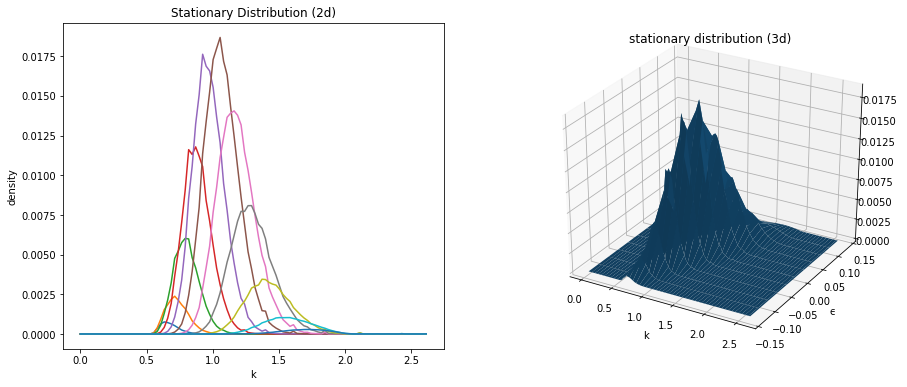

In [13]:
# Plot the policy function (labor)

fig = plt.figure(figsize = [15, 6])

fig.add_subplot(121)
for iz in range(nϵ):
    plt.plot(kgrid, g_dist[:,iz])
plt.title("Stationary Distribution (2d)")
plt.xlabel("k")
plt.ylabel("density")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(np.reshape(kgrid,(nk,1)), np.reshape(ϵgrid,(1,nϵ)), g_dist)
plt.xlabel("k"); plt.ylabel("ϵ"); plt.title("stationary distribution (3d)")
plt.show()

In [14]:
'''
----------------------------------------------
 [Step 2] : solve for the mass of entrants m*
----------------------------------------------
'''

def labor_market_clear(m, Ns, g_dist, mPn):
    '''
    This function checks if the labor market clears (labor demand[Nd] = labor supply[Ns])
    
    [ Parameters ]
        m      : the mass of entrants
        Ns     : the targeted labor supply
        g_dist : the stationary distribution
        mPn    : the optimal labor choice n(k,ϵ)
        
    [ Return ]
        |Ns - Nd| : a difference between the labor supply and demand
    '''
    g_dist_star = m * g_dist   # g is linearly homogenous in m : g(m*) = m* g(1)
    Nd = np.sum(np.multiply(mPn, g_dist_star))  # compute the labor demand
    return np.abs(Nd - Ns)

mstar = fsolve(labor_market_clear, 1, args=(0.6,g_dist,mPn))
print("m* = %4.2f" % mstar)

m* = 0.96


In [15]:
def compute_cons(w, Ns, kgrid, ϵgrid, mPk, mPn, g_dist, params):
    '''
    This function computes the aggregate consumption
    
    [ Parameters ]
        w      : wage
        Ns     : labor supply
        kgrid  : a grid for k (capital) 
        ϵgrid  : a grid for ϵ (idiosyncratic shock)
        mPk    : the optimal capital chocie k(k,ϵ)
        mPn    : the optimal labor choice n(k,ϵ)
        g_dist : the stationary distribution g(k,ϵ)
        params : theta, nu, delta, beta, varphi, rrho, sigma
        
    [ Return ]
        C : the aggregate consumption (C = w*Ns + π)
    '''
    
    θ, ν, δ, β, φ, ρ, σ = params
    
    nk = len(kgrid)
    nϵ = len(ϵgrid)
    C = w*Ns
    
    for ik in range(nk):
        k = kgrid[ik]
        for iϵ in range(nϵ):
            if mPd[ik,iϵ] == 0:
                π = (1-δ)*k  # firms exit
                C += π*g_dist[ik,iϵ]
            else:
                if k == 0:
                    π = - mPk[ik,iϵ]  # new firms enter
                    C += π*g_dist[ik,iϵ]
                else:
                    ϵ = ϵgrid[iϵ]
                    y = np.exp(ϵ)*(k**θ)*(mPn[ik,iz]**ν)
                    n = mPn[ik,iϵ]
                    kp = mPk[ik,iϵ]
                    π = y - w*n - (kp-(1-δ)*k) - 0.5*φ*k*(kp/k - (1-δ))**2  # incumbent firms operate
                    C += π*g_dist[ik,iϵ]
    return C

Ns = 0.6
C = compute_cons(wss, Ns, kgrid, ϵgrid, mPk, mPn, g_dist, params)
a = wss/C

print("C = %4.2f" % (C))
print("a = %4.2f" % (a))

C = 0.82
a = 0.94


In [ ]:
'''
========================================
 6. Calibrate the entry and exit costs
========================================
'''

def calibration(x, t1, t2, kss, nk, nϵ, mstar, params):
    '''
    This function is used for the calibration.
    I choose Cf (fixed cost to opearte) and w (wage) ["instead of choosing Ce"] to match 
    the exit rate and the relative average size of new firms to incumbent firms
    
    [ Parameters ]
        x[0]   : a fixed cost that incumbent firms pay to operate (Cf)
        x[1]   : wage (w)
        t1     : target 1 ~ the exit rate
        t2     : target 2 ~ the relative average size of new firms to incumbent firms
        kss    : the steady state capital stock
        nk     : a number of points for k (capital)
        nϵ     : a number of points for ϵ (idiosyncratic shock)
        mstar  : the mass of entrants
        params : theta, nu, delta, beta, varphi, rrho, sigma
        
    [ Return ]
        exit - t1 : the difference between the computed exit rate and the target
        size - t2 : the difference between the computed relative size and the target
    '''
    
    Cf = x[0]
    w = x[1]
    
    # implement the value function iteration given Cf and w
    mV, mPd, mPk, mPn, kgrid, ϵgrid, MC = VFI(w, kss, nk, nϵ, Cf, params, Max_Iter=1000, tol=1e-5, seeIter=0);
    
    # compute Ce
    Ce = np.dot(mV[0,:], ν_dist)
    
    # compute the stationary distribution
    mT = transition_matrix(nk, nϵ, MC, mPk)
    g_dist_init = np.zeros((nk, nϵ))
    g_dist = stationary_dist(nk, nϵ, mT, mPk, mPd, g_dist_init, ν_dist, mstar, Max_Iter=100, tol=1e-6, seeIter=0);
    
    # compute the implied exit rate
    exit = 1 - np.sum(np.multiply(mPd, g_dist))
    
    # compute the implied relative size
    incumbent_avg_size = np.sum(np.multiply(g_dist, np.matlib.repmat(np.reshape(kgrid,(nk,1)), 1, nϵ)))
    entrant_avg_size = np.dot(ν_dist, np.multiply(mPd[0,:], mPk[0,:]))
    size = entrant_avg_size / incumbent_avg_size
    
    print("Cf = %4.3f,  Ce = %4.3f,  w* = %4.3f,  exit = %4.3f,  size = %4.3f" 
      % (Cf, Ce, w, exit, size))
    
    return (exit-t1, size-t2)

# find Ce and w to match exit rate = 5% and the relative size = 50%
exit_target = 0.05
size_target = 0.50
x0 = np.array([0.1, wss]) # initial guess: Cf = 0.1, w = wss
sol = fsolve(calibration, x0, args=(exit_target, size_target, Kss, nk, nϵ, mstar, params))